1) Imports & configuration

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



In [ ]:
import warnings, os
warnings.filterwarnings("ignore")

# Optional (for time-series with exogenous ad_spend)

In [ ]:
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    HAS_STATS = True
except Exception:
    HAS_STATS = False

2) (Optional) Make a tiny demo dataset you can run now

In [ ]:
np.random.seed(42)
dates = pd.date_range("2024-11-01", periods=120, freq="D")
platforms = np.random.choice(["Google","Meta","TV","Influencer","Email"], size=len(dates))
segments = np.random.choice(["New","Returning","SMB","Enterprise"], size=len(dates))

ad_spend = np.random.gamma(shape=15, scale=120, size=len(dates))  # skewed like real spend
impressions = np.clip((ad_spend*50 + np.random.normal(0, 2e3, len(dates))).astype(int), 0, None)
clicks = np.clip((impressions*0.03 + np.random.normal(0, 200, len(dates))).astype(int), 0, None)
conversions = np.clip((clicks*0.07 + np.random.normal(0, 20, len(dates))).astype(int), 0, None)
avg_order_value = np.random.normal(45, 5, len(dates)).clip(20, 80)
discount_rate = np.random.choice([0.0,0.05,0.1,0.15], size=len(dates))
units_in_stock = np.random.randint(600, 1000, len(dates))
price_index = np.random.normal(1.0, 0.05, len(dates)).clip(0.85, 1.15)
holiday = (pd.Series(dates).dt.dayofweek.isin([5,6])).astype(int)  # weekends as pseudo-holidays
region = np.random.choice(["North","South","East","West"], size=len(dates))

# true sales signal (ad_spend + seasonality + noise)
true_sales = (
    2.0*ad_spend
    + 0.05*impressions
    + 80*conversions
    + (avg_order_value * 5)
    - 500*discount_rate
    + 800*holiday
    + np.sin(np.arange(len(dates))/7)*500
    + np.random.normal(0, 1500, len(dates))
).clip(5000, None)

demo = pd.DataFrame({
    "date": dates,
    "sales": true_sales.round(0),
    "ad_spend": ad_spend.round(2),
    "platform": platforms,
    "segment": segments,
    "impressions": impressions,
    "clicks": clicks,
    "conversions": conversions,
    "avg_order_value": avg_order_value.round(2),
    "discount_rate": discount_rate,
    "units_in_stock": units_in_stock,
    "price_index": price_index.round(3),
    "holiday": holiday,
    "region": region
})
demo.to_csv("/content/Advertising.csv", index=False)

3) Load your data & quick checks

In [ ]:
df = pd.read_csv("/content/Advertising.csv")

In [ ]:
df

,date,sales,ad_spend,platform,segment,impressions,clicks,conversions,avg_order_value,discount_rate,units_in_stock,price_index,holiday,region
0,2024-11-01,25430.0,2149.13,Influencer,Returning,109772,3366,194,43.80,0.05,929,1.001,0,East
1,2024-11-02,17136.0,1374.28,Email,Enterprise,70297,1920,114,43.13,0.10,706,1.064,1,West
2,2024-11-03,24318.0,2043.71,TV,New,103433,3000,172,48.55,0.00,825,1.010,1,East
3,2024-11-04,35261.0,2970.78,Email,SMB,149795,4282,292,47.22,0.10,912,1.002,0,West
4,2024-11-05,19148.0,1342.90,Email,SMB,67120,2001,140,43.20,0.15,817,0.932,0,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2025-02-24,24589.0,1769.67,Email,SMB,88418,3067,192,42.42,0.05,757,0.976,0,North
116,2025-02-25,22216.0,1913.22,Meta,Enterprise,91526,2920,193,45.48,0.00,638,0.984,0,West
117,2025-02-26,21689.0,1700.87,TV,SMB,84865,2480,183,42.69,0.10,681,1.021,0,West
118,2025-02-27,17518.0,1410.12,Google,SMB,67896,2277,134,42.83,0.00,955,1.026,0,West


In [ ]:
df.head(5)

,date,sales,ad_spend,platform,segment,impressions,clicks,conversions,avg_order_value,discount_rate,units_in_stock,price_index,holiday,region
0,2024-11-01,25430.0,2149.13,Influencer,Returning,109772,3366,194,43.80,0.05,929,1.001,0,East
1,2024-11-02,17136.0,1374.28,Email,Enterprise,70297,1920,114,43.13,0.10,706,1.064,1,West
2,2024-11-03,24318.0,2043.71,TV,New,103433,3000,172,48.55,0.00,825,1.010,1,East
3,2024-11-04,35261.0,2970.78,Email,SMB,149795,4282,292,47.22,0.10,912,1.002,0,West
4,2024-11-05,19148.0,1342.90,Email,SMB,67120,2001,140,43.20,0.15,817,0.932,0,South


In [ ]:
df.shape

(120, 14)

In [ ]:
df.columns.tolist()

['date',
 'sales',
 'ad_spend',
 'platform',
 'segment',
 'impressions',
 'clicks',
 'conversions',
 'avg_order_value',
 'discount_rate',
 'units_in_stock',
 'price_index',
 'holiday',
 'region']

# Ensure date is datetime and sorted (if present)

In [ ]:
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date")

3) Basic cleaning (missing values, types)
# We need 'sales' (target) and 'ad_spend' (key driver)

In [ ]:
df = demo.dropna(subset=["sales", "ad_spend"])

# Split numeric vs categorical for simple imputation

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.drop("Sales", errors="ignore")

In [ ]:
cat_cols = df.select_dtypes(include=["object","category"]).columns

# Fill numerics with median, categoricals with "Unknown"

In [ ]:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

In [ ]:
df[cat_cols] = df[cat_cols].fillna("Unknown")

3) Feature engineering (CTR, CVR, log, date parts)
# CTR & CVR

In [ ]:
if {"impressions","clicks"}.issubset(df.columns):
    df["ctr"] = np.where(df["impressions"]>0, df["clicks"]/df["impressions"], 0.0)
else:
    df["ctr"] = 0.0

In [ ]:
if {"clicks","conversions"}.issubset(df.columns):
    df["cvr"] = np.where(df["clicks"]>0, df["conversions"]/df["clicks"], 0.0)
else:
    df["cvr"] = 0.0

# Discounted AOV (optional)

In [ ]:
if {"avg_order_value","discount_rate"}.issubset(df.columns):
    df["effective_aov"] = df["avg_order_value"] * (1 - df["discount_rate"].clip(0,1))

## Log of ad spend for diminishing returns patterns

In [ ]:
df["log_ad_spend"] = np.log1p(df["ad_spend"])

## Date features to capture seasonality

In [ ]:
if "date" in df.columns and df["date"].notna().any():
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
else:
    df["dow"] = 0
    df["month"] = 0

4) Choose features + split train/test (time-aware)
target = "sales"
# Pick features you actually have

In [ ]:
num_features = [c for c in [
    "ad_spend","log_ad_spend","impressions","clicks","conversions",
    "ctr","cvr","avg_order_value","effective_aov","discount_rate",
    "units_in_stock","price_index","holiday","dow","month"
] if c in df.columns]

cat_features = [c for c in ["platform","segment","region"] if c in df.columns]

X = df[num_features + cat_features]
y = df["sales"].values

# Time-aware split if date exists, else random split

In [ ]:
if "date" in df.columns and df["date"].notna().any():
    cutoff = int(len(df)*0.8)
    X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
    y_train, y_test = y[:cutoff], y[cutoff:]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (96, 18)  Test shape: (24, 18)


5) Preprocessing (scale numbers, one-hot encode categories)

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ],
    remainder="drop"
)

6) Train two models (Linear & Random Forest) and pick the best

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def fit_eval(pipe, name):
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    r2   = r2_score(y_test, pred)
    mae  = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))  # <-- FIXED
    print(f"{name} -> R2: {r2:.3f} | MAE: {mae:,.1f} | RMSE: {rmse:,.1f}")
    return pipe, {"r2": r2, "mae": mae, "rmse": rmse}

# now run
m_lin, s_lin = fit_eval(lin_model, "Linear")
m_rf,  s_rf  = fit_eval(rf_model,  "RandomForest")

best_model = m_rf if s_rf["r2"] >= s_lin["r2"] else m_lin
print("Selected best model:", type(best_model.named_steps["model"]).__name__)


Linear -> R2: 0.930 | MAE: 1,205.1 | RMSE: 1,500.4
RandomForest -> R2: 0.894 | MAE: 1,620.4 | RMSE: 1,851.7
Selected best model: LinearRegression


7) Explain drivers: permutation importance + ad_spend partial dependence
# Permutation importance works on any sklearn model


Top drivers:
             feature  importance
4       conversions    1.148776
0          ad_spend    0.348950
8     effective_aov    0.204409
9     discount_rate    0.134177
3            clicks    0.111578
7   avg_order_value    0.109775
2       impressions    0.103232
5               ctr    0.025572
15         platform    0.011846
16          segment    0.009392
1      log_ad_spend    0.007494
12          holiday    0.004072


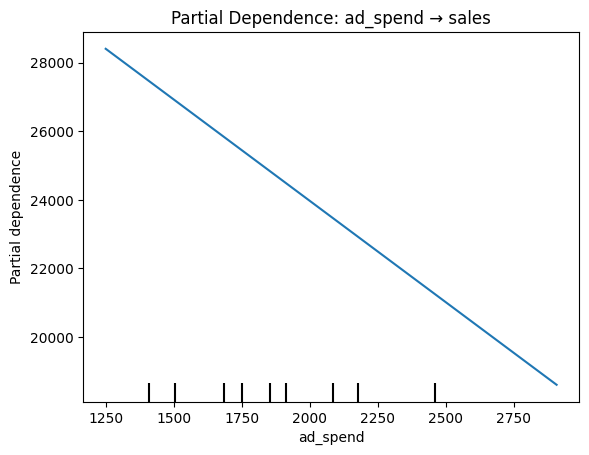

In [ ]:
perm = permutation_importance(best_model, X_test, y_test, n_repeats=8, random_state=42)
imp_df = pd.DataFrame({"feature": X_test.columns, "importance": perm.importances_mean}) \
         .sort_values("importance", ascending=False)
print("\nTop drivers:\n", imp_df.head(12))

# Partial dependence for ad_spend (if present)
if "ad_spend" in num_features:
    PartialDependenceDisplay.from_estimator(best_model, X_test, ["ad_spend"])
    plt.title("Partial Dependence: ad_spend → sales")
    plt.show()

8) “What-if” simulator: change ad spend and see uplift (+ ROI)

In [ ]:
def simulate_spend_change(model, X_ref: pd.DataFrame, pct_change: float, scope: dict|None=None):
    """
    pct_change: +0.10 for +10% ; -0.10 for -10%
    scope: limit where change applies, e.g. {"platform":"Google"} or {"segment":"New"}
    """
    X_new = X_ref.copy()
    mask = pd.Series(True, index=X_new.index)
    if scope:
        for k, v in scope.items():
            if k in X_new.columns:
                mask &= (X_new[k] == v)

 # apply change

In [ ]:
def simulate_spend_change(model, X_ref, pct_change=0.1, scope=None):
    X_new = X_ref.copy()

    if "ad_spend" not in X_new.columns:
        raise ValueError("Column 'ad_spend' not found in dataset!")

    # Scope handling
    if scope is None:
        mask = np.ones(len(X_new), dtype=bool)   # all rows
    elif isinstance(scope, dict):
        # Build mask from column conditions
        mask = np.ones(len(X_new), dtype=bool)
        for col, val in scope.items():
            mask &= (X_new[col] == val)
    else:
        mask = scope   # assume already boolean mask

    # Apply ad spend change
    X_new.loc[mask, "ad_spend"] *= (1 + pct_change)

    if "log_ad_spend" in X_new.columns:
        X_new["log_ad_spend"] = np.log1p(X_new["ad_spend"])

    # Predictions
    base = model.predict(X_ref)
    scen = model.predict(X_new)

    out = pd.DataFrame({
        "baseline": base,
        "scenario": scen,
        "uplift": scen - base,
        "uplift_%": np.where(base != 0, (scen - base) / np.maximum(base, 1e-9), np.nan)
    }, index=X_ref.index)

    return out



In [ ]:
def est_roi(uplift_sales_sum: float, extra_spend_sum: float, margin_rate: float=0.6) -> float:
    """Very simple ROI estimate."""
    return (uplift_sales_sum*margin_rate - extra_spend_sum) / max(extra_spend_sum, 1e-9)

# Example 1: +10% ad spend on all test rows

In [ ]:
whatif_all = simulate_spend_change(best_model, X_test, pct_change=+0.10, scope=None)
print("\nWhat-if +10% overall (test set):")
print(whatif_all.describe()[["uplift","uplift_%"]])


What-if +10% overall (test set):
            uplift   uplift_%
count    24.000000  24.000000
mean   -881.057809  -0.035746
std     236.811698   0.004016
min   -1481.754075  -0.044984
25%   -1041.355573  -0.038829
50%    -858.573603  -0.035061
75%    -726.645037  -0.034074
max    -501.965458  -0.028501


# Example 2: +15% only for the most common platform (if available)

In [ ]:
if "platform" in X_test.columns:
    top_platform = X_test["platform"].mode().iloc[0]
    whatif_plat = simulate_spend_change(best_model, X_test, pct_change=+0.15, scope={"platform": top_platform})
    print(f"\nWhat-if +15% only on platform={top_platform}:")
    print(whatif_plat.describe()[["uplift","uplift_%"]])


What-if +15% only on platform=Google:
            uplift   uplift_%
count    24.000000  24.000000
mean   -341.853604  -0.013035
std     627.425281   0.023171
min   -1807.865116  -0.057204
25%    -225.677526  -0.010776
50%       0.000000   0.000000
75%       0.000000   0.000000
max       0.000000   0.000000


# Simple ROI back-of-the-envelope (assuming margin 60%)

In [ ]:
if "ad_spend" in X_test.columns:
    extra_spend = (X_test["ad_spend"]*0.10).sum()   # total +10% cost in test window
    uplift_sales = whatif_all["uplift"].sum()
    roi = est_roi(uplift_sales, extra_spend, margin_rate=0.6)
    print(f"\nEstimated ROI for +10% spend: {roi:.2f} (margin=60%)")



Estimated ROI for +10% spend: -3.79 (margin=60%)


 9) Time-series forecast with ad_spend as exogenous (SARIMAX)

Use this when you have a date column (daily/weekly) and want a short-term forecast and scenario curves for ad spend.

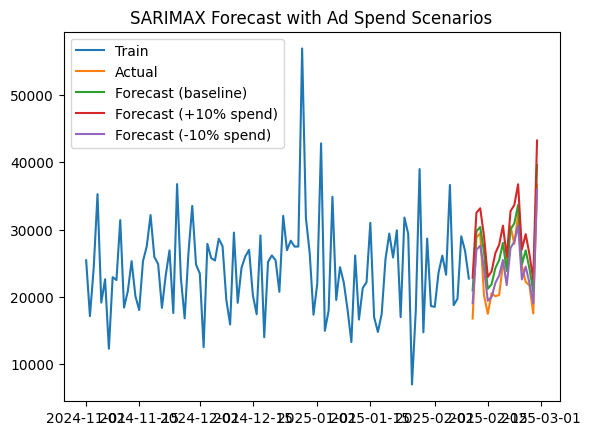

In [ ]:
if HAS_STATS and "date" in df.columns and df["date"].notna().any():
    # Aggregate to daily and interpolate small gaps
    ts = df[["date","sales","ad_spend"]].groupby("date", as_index=False).sum().set_index("date").asfreq("D")
    ts["sales"] = ts["sales"].interpolate()
    ts["ad_spend"] = ts["ad_spend"].interpolate()

    split = int(len(ts)*0.85)
    train, test = ts.iloc[:split], ts.iloc[split:]

    # Basic seasonal weekly model
    model_ts = SARIMAX(train["sales"], exog=train[["ad_spend"]],
                       order=(1,1,1), seasonal_order=(1,1,1,7),
                       enforce_stationarity=False, enforce_invertibility=False)
    fit = model_ts.fit(disp=False)

    # Baseline forecast
    fc_base = fit.get_forecast(steps=len(test), exog=test[["ad_spend"]]).predicted_mean

    # Scenario: +10% ad spend in the forecast window
    exog_plus = test[["ad_spend"]] * 1.10
    fc_plus = fit.get_forecast(steps=len(test), exog=exog_plus).predicted_mean

    # Scenario: -10% ad spend
    exog_minus = test[["ad_spend"]] * 0.90
    fc_minus = fit.get_forecast(steps=len(test), exog=exog_minus).predicted_mean

    # Plot
    plt.figure()
    plt.plot(train.index, train["sales"], label="Train")
    plt.plot(test.index, test["sales"], label="Actual")
    plt.plot(test.index, fc_base, label="Forecast (baseline)")
    plt.plot(test.index, fc_plus, label="Forecast (+10% spend)")
    plt.plot(test.index, fc_minus, label="Forecast (-10% spend)")
    plt.title("SARIMAX Forecast with Ad Spend Scenarios")
    plt.legend()
    plt.show()
else:
    print("Skipping SARIMAX (no statsmodels or no usable 'date').")


10) Turn model outputs into actionable insights

In [ ]:
print("\n--- Actionable Insights ---")

# 1) Top drivers
print("Top 5 drivers right now:")
print(imp_df.head(5).to_string(index=False))

# 2) Elasticity near current levels (rough)
if "uplift_%" in whatif_all:
    elastic = float(whatif_all["uplift_%"].replace([np.inf,-np.inf], np.nan).dropna().mean()*100)
    print(f"Approx. elasticity: +10% ad spend → ~{elastic:.1f}% sales change (at current levels).")

# 3) Budget direction
if "platform" in X_test.columns:
    # Compare ROI-like metric per platform: uplift / extra_spend
    rows = []
    for p in X_test["platform"].unique():
        w = simulate_spend_change(best_model, X_test, pct_change=+0.10, scope={"platform": p})
        extra = float((X_test.loc[X_test["platform"]==p, "ad_spend"]*0.10).sum())
        uplift = float(w["uplift"].sum())
        if extra > 0:
            rows.append([p, uplift/extra])
    if rows:
        roi_rank = pd.DataFrame(rows, columns=["platform","uplift_per_extra_currency"]).sort_values(
            "uplift_per_extra_currency", ascending=False)
        print("\nWhere to add budget first (higher is better):")
        print(roi_rank.to_string(index=False))


--- Actionable Insights ---
Top 5 drivers right now:
      feature  importance
  conversions    1.148776
     ad_spend    0.348950
effective_aov    0.204409
discount_rate    0.134177
       clicks    0.111578
Approx. elasticity: +10% ad spend → ~-3.6% sales change (at current levels).

Where to add budget first (higher is better):
  platform  uplift_per_extra_currency
Influencer                  -4.462950
        TV                  -4.556980
    Google                  -4.685877
      Meta                  -4.719402
     Email                  -4.787620
